In [1]:
import tensorflow as tf
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
import numpy as np
import time
from scipy.io import wavfile
import random
import sys
import io
import os
import pathlib
import glob
from datetime import datetime as dt
from numpy import log as ln
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import IPython
import IPython.display as ipd
import tensorflow as tf
%matplotlib inline
import pyaudio
from queue import Queue
from threading import Thread
import math
import time
import librosa

In [2]:
i16min            = -32768
i16max            = 32767
fsamp             = 16000
wave_length_ms    = 1000
wave_length_samps = 16000
window_size_ms    = 60
window_step_ms    = 40
num_filters       = 32
use_microfrontend = True
keyword        = 'marius'#####Insert your keyword
spectrogram_shape = (64, 24, 32, 1)

chunk_duration = 0.25 # Each read length in seconds from mic.
fs = 16000 # sampling rate for mic
sample_rate = 16000 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 1.0
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

In [3]:
parent_dir = os.getcwd() #gets current directory
folder_pre = "" 
folder = folder_pre + keyword #name of directory
dir = os.path.join(parent_dir,folder)
noise_dir=os.path.join(parent_dir,"noise")
# os.mkdir(dir) #creating folder
# os.mkdir(noise_dir) #creating folder
keyword_directory=dir + '\\'   
print("Directory '% s' created" % folder)
print("Directory 'noise' created")

Directory 'marius' created
Directory 'noise' created


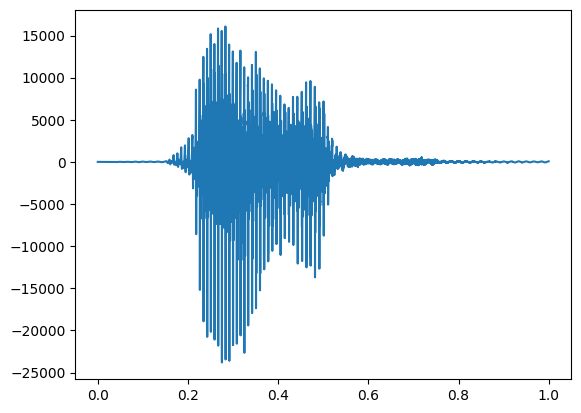

Audio sample saved


In [104]:
# Queue to communiate between the audio callback and main thread
q = Queue()
run = True
silence_threshold = 100
# Run the demo for a timeout seconds
timeout = time.time() + 1 
# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()
try:
    while run:        
        data = q.get()
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False      
stream.stop_stream()
stream.close()

sample_rate = fs

#Displaying wave file data
plt.plot(np.arange(1*fs)/fs, data)
plt.show()
ipd.Audio(data, rate=fs)

noise = False

if not noise:
    # #saving the wave file to training_data
    date_str = dt.now().strftime("%H%M%S").lower()
    current_name = f"{keyword_directory}{keyword}_{date_str}.wav"
    write(current_name, sample_rate, data)
    print("Audio sample saved")

else:
    # #saving the wave file to training_data
    date_str = dt.now().strftime("%H%M%S").lower()
    current_name = f"{parent_dir}/noise/noise_{date_str}.wav"
    write(current_name, sample_rate, data)
    print("Audio sample saved as noise")


### Time Shift

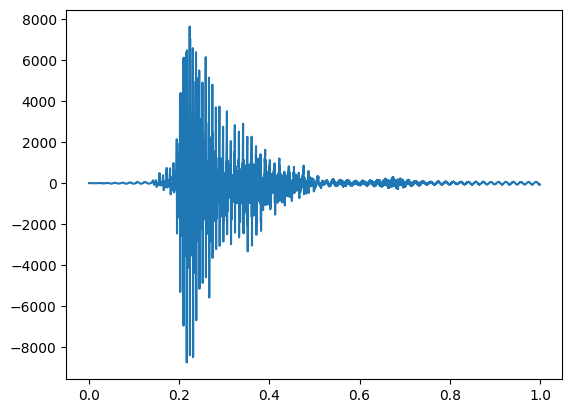

In [4]:
#Need to update filenames
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
filenames[0]
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [5]:
#initializing variables for 1/8th second time shifts
one_eighth=int((sample_rate/16)) #16k sample rate means 2k for 1/8s
padding=one_eighth #Number of samples to pad
#zero_padding=np.zeros(padding).astype(np.int16) #array of empty audio to pad with
noise_lvl_min=-200 #about the min for quiet room when measured with get audio code above
noise_lvl_max=200 #about the max for quiet room when measured with get audio code above
noise_padding=np.random.randint(noise_lvl_min,noise_lvl_max+1,padding) #makes random noise

left_3=1
left_2=1
left_1=2
zero_shift=2
right_1=2
right_2=1
right_3=1

total=zero_shift+right_3+right_2+right_1+left_3+left_2+left_1
print("This will expand the current", len(filenames), "files by creating an addtional",len(filenames)*total, "time shifted files, to give a total of",len(filenames)*(total+1),"files")

This will expand the current 41 files by creating an addtional 410 time shifted files, to give a total of 451 files


In [6]:
#creates dictionary to hold audio for data visualization
audio_dict={}

##This will randomize audio samples
#random_list = list(range(0, len(filenames))) #create array [1,2,3...]
#random.shuffle(random_list) #randomize the array

#This will reverse the list so the element printed in next cell shows augmentation to original sample
random_list = list(range(0, len(filenames))) #create array [1,2,3...]
random_list.reverse() #randomize the array

#runs 5x shifts audio from original to left by .5sec in 1/8s increments
for index in range(len(filenames)):
    test_wav=filenames[random_list[index]]
    fs, test_wav = wavfile.read(test_wav)
    audio_dict[0]=test_wav.astype(np.int16)#dict[0] holds original audio
    test_wav_decrease = test_wav #creating copy to be manipulated 
    test_wav_increase = test_wav #creating copy to be manipulated
    
    #shift audio to left in 1/8s increments
    for j in range(1,4):#dict 1-4 hold shifted audio (change 4 to 5 to make 1/2s shift)
        for i in range (one_eighth):
            test_wav_decrease=np.delete(test_wav_decrease,0)
        test_wav_decrease=np.concatenate((test_wav_decrease,noise_padding),axis=0).astype(np.int16)
        audio_dict[j]=test_wav_decrease.astype(np.int16)
        if (j==1):
            for p in range(left_1): #creates left_1 copys shifted left 1/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (j==2):
            for p in range(left_2): #creates left_2 copys shifted left 2/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (j==3):
            for p in range(left_3): #creates left_3 copy shifted left 3/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)

    
    #shift audio to right in 1/8s increments
    for k in range(6,9):
        #pad zeros to front
        test_wav_increase=np.concatenate((noise_padding,test_wav_increase),axis=0)
        #delete data past 16k samples
        for d in range(sample_rate,len(test_wav_increase)):
            test_wav_increase=np.delete(test_wav_increase,sample_rate,0).astype(np.int16)
        audio_dict[k]=test_wav_increase
        if (k==6):
            for p in range(right_1): #creates right_1 copys shifted right 1/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (k==7):
            for p in range(right_2): #creates right_2 copys shifted right 2/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (k==8):
            for p in range(right_3): #creates right_3 copy shifted right 3/8s
                current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
    for l in range(zero_shift):
        current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_NoShift_{l}.wav"
        write(current_name, fs, test_wav)

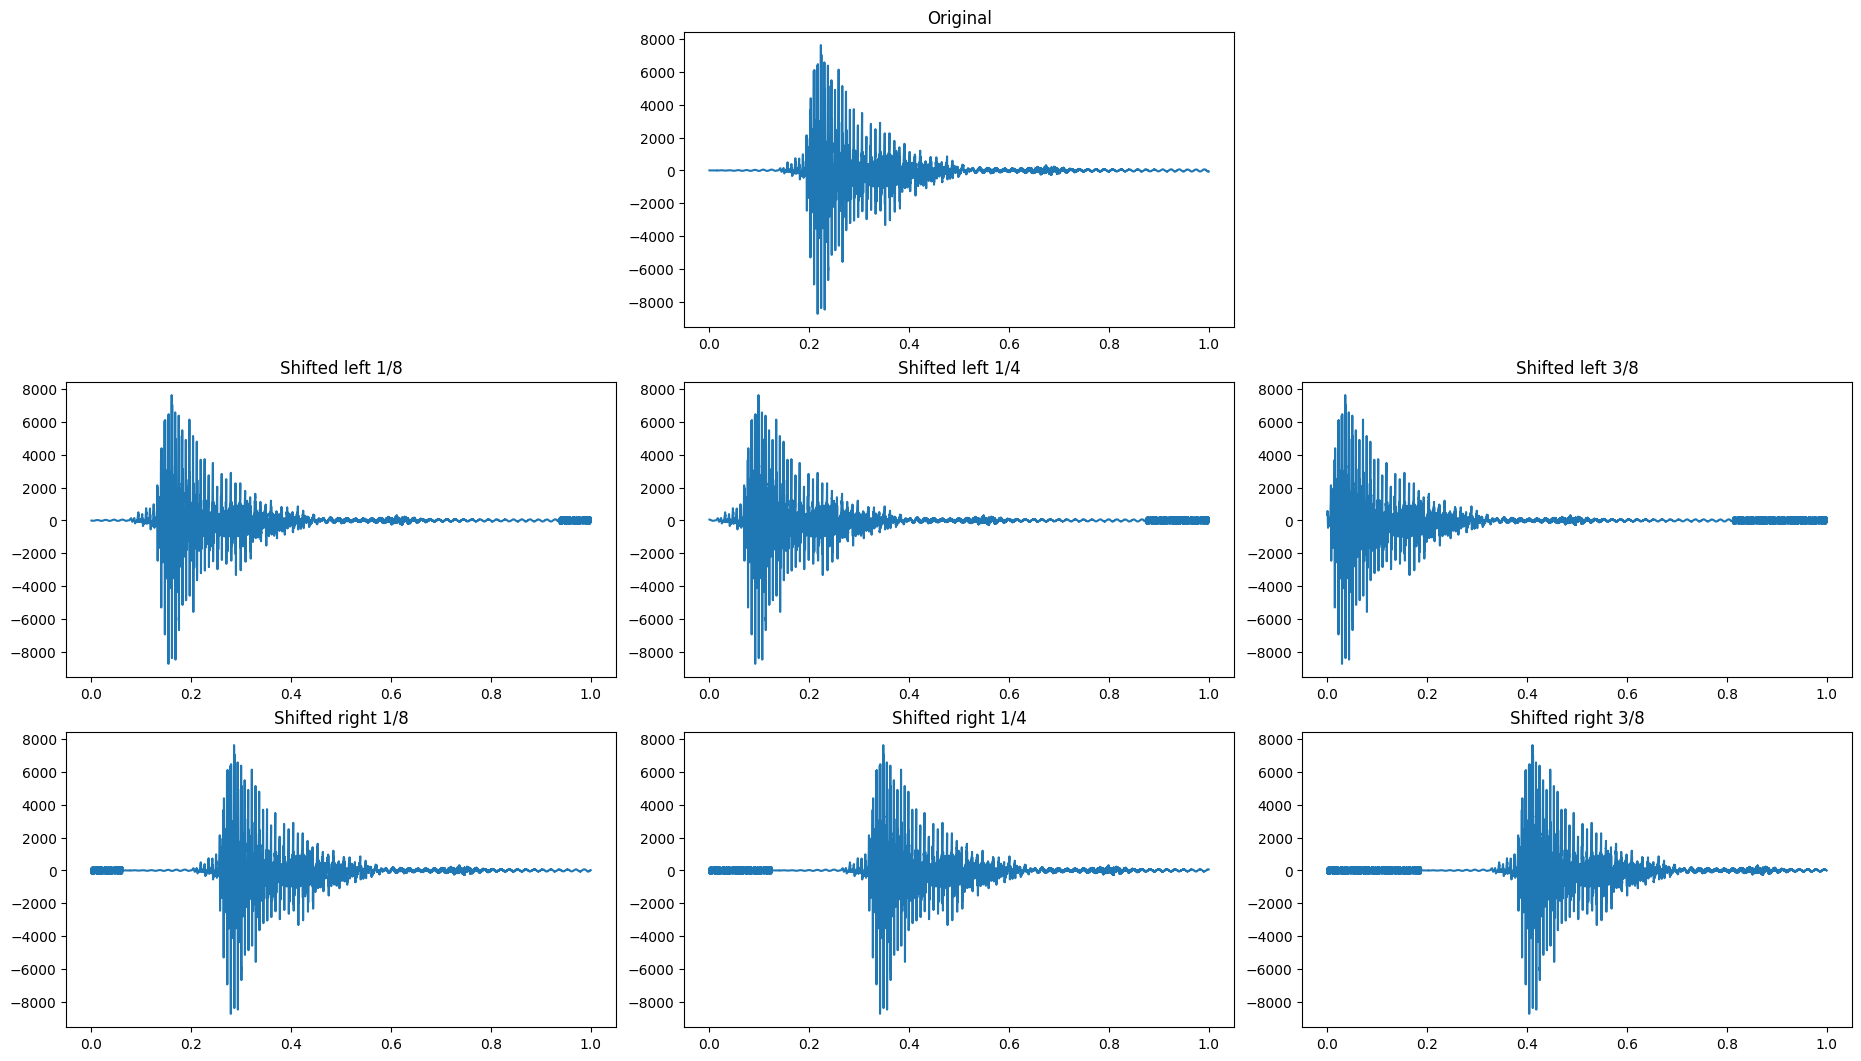

In [7]:
#commented out is for half second shift if desired

fig = plt.figure(constrained_layout=True)
axs = fig.add_gridspec(3, 3)

f_ax0 = fig.add_subplot(axs[0, 1])
f_ax1 = fig.add_subplot(axs[1, 0])
f_ax2 = fig.add_subplot(axs[1, 1])
f_ax3 = fig.add_subplot(axs[1, 2])
# f_ax4 = fig.add_subplot(axs[2, 3])
f_ax6 = fig.add_subplot(axs[2, 0])
f_ax7 = fig.add_subplot(axs[2, 1])
f_ax8 = fig.add_subplot(axs[2, 2])
# f_ax9 = fig.add_subplot(axs[3, 3])

f_ax0.plot(np.arange(1*fs)/fs, audio_dict[0])
f_ax1.plot(np.arange(1*fs)/fs, audio_dict[1])
f_ax2.plot(np.arange(1*fs)/fs, audio_dict[2])
f_ax3.plot(np.arange(1*fs)/fs, audio_dict[3])
# f_ax4.plot(np.arange(1*fs)/fs, audio_dict[4])
f_ax6.plot(np.arange(1*fs)/fs, audio_dict[6])
f_ax7.plot(np.arange(1*fs)/fs, audio_dict[7])
f_ax8.plot(np.arange(1*fs)/fs, audio_dict[8])
# f_ax9.plot(np.arange(1*fs)/fs, audio_dict[9])

f_ax0.set_title('Original')
f_ax1.set_title('Shifted left 1/8')
f_ax2.set_title('Shifted left 1/4')
f_ax3.set_title('Shifted left 3/8')
# f_ax4.set_title('Shifted left 1/2')
f_ax6.set_title('Shifted right 1/8')
f_ax7.set_title('Shifted right 1/4')
f_ax8.set_title('Shifted right 3/8')
# f_ax9.set_title('Shifted right 1/2')
fig.set_size_inches(18.5, 10.5, forward=True)
pass

In [8]:
from IPython.display import Audio 
from IPython.display import display

print("Original:")
display(Audio(audio_dict[0], rate=fs))
print("Shifted left 1/8:")
display(Audio(audio_dict[1], rate=fs))
print("Shifted left 1/4:")
display(Audio(audio_dict[2], rate=fs))
print("Shifted left 3/8:")
display(Audio(audio_dict[3], rate=fs))
# print("Shifted left 1/2:")
# display(Audio(audio_dict[4], rate=fs))
print("Shifted right 1/8:")
display(Audio(audio_dict[6], rate=fs))
print("Shifted right 1/4:")
display(Audio(audio_dict[7], rate=fs))
print("Shifted right 3/8:")
display(Audio(audio_dict[8], rate=fs))
# print("Shifted right 1/2:")
# display(Audio(audio_dict[9], rate=fs))

Original:


Shifted left 1/8:


Shifted left 1/4:


Shifted left 3/8:


Shifted right 1/8:


Shifted right 1/4:


Shifted right 3/8:


### Pitch Shift

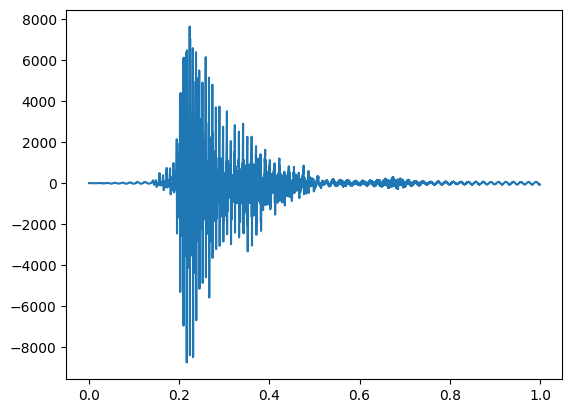

In [9]:
#Need to update filenames
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
filenames[0]
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [10]:
#How many of the files do you want to have total?
desired_number_of_files=3000

#How do you want to pitch shift
    #positive=high pitch, negative = low pitch
    #0.25 is a good value
pitch_shift=0.25

In [11]:
#Doubling formula used to find range for outer for loop indexing with "i"
outer_range= math.ceil((np.log(desired_number_of_files / len(filenames)) / np.log(2) ))
outer_range

3

In [12]:
#replace line 11 with comment below if you want to create a custom # < len(filenames)...
#                                                    ...comment out if statements and speed will improve significantly
#for index in range(40000): 

pitch_dict={}
for i in range(outer_range):
    for index in range(len(filenames)):
        test_wav=filenames[index]
        fs, test_wav = wavfile.read(test_wav)
#         if i==0:
#             pitch_dict[i]=test_wav
        test_wav_float=test_wav.astype(float)
        test_wav_pitch_shifted = librosa.effects.pitch_shift(test_wav_float, sr=sample_rate, n_steps=pitch_shift*(i+1))
        test_wav_pitch_shifted_int=test_wav_pitch_shifted.astype(np.int16)
        current_name = str(keyword_directory)+str(keyword) +f"_Pitch_Shift_{i}_{index}.wav"    
        write(current_name, fsamp, test_wav_pitch_shifted_int)

        files_in_folder=len(tf.io.gfile.glob(str(data_dir) + '/*.wav'))
        pitch_dict[i+1]=test_wav_pitch_shifted_int
        if (files_in_folder >= desired_number_of_files):
            break 
    filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
    #update filenames with newly created files    
    if (files_in_folder >= desired_number_of_files):
        break 
print("Congratulations, the current number of files in directory is", len(filenames))

Congratulations, the current number of files in directory is 3000


### Noise

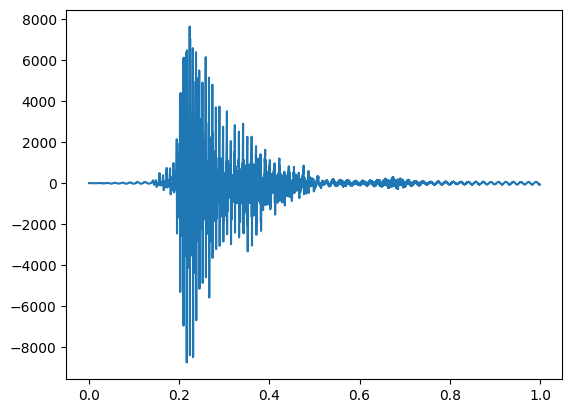

In [114]:
#Selecting augmentation folder & files
data_dir = dir
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')

#Testing if audio data imported correctly
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [13]:
noise_dir = parent_dir+'\\noise'
noise_samples = tf.io.gfile.glob(str(noise_dir) + '/*.wav')
print("Noise Samples:", len(noise_samples))

Noise Samples: 4


In [14]:
noise_count=1
print("This will expand the current", len(filenames), "files by creating an addtional",len(filenames)*len(noise_samples)*noise_count, "noise augmented files, to give a total of",len(filenames)*len(noise_samples)*(noise_count)+len(filenames),"files")

This will expand the current 3000 files by creating an addtional 12000 noise augmented files, to give a total of 15000 files


In [15]:
#dict holds samples for plotting
noise_dict={}
for index in range(len(filenames)):
    test_wav=filenames[index]
    fs, test_wav = wavfile.read(test_wav)
    if (len(test_wav) < fs):
        padding=fs-len(test_wav)
        extra_padding=np.zeros(padding).astype(np.int16) #array of empty audio to pad with
        test_wav=np.concatenate((test_wav,extra_padding),axis=0).astype(np.int16)
    noise_dict[0]=test_wav.astype(np.int16)
    for i in range(len(noise_samples)):
        noise=noise_samples[i]
        fs, noise = wavfile.read(noise)
        for j in range(noise_count):
            noise_multiplier=round(max(test_wav)*(j/2000))
            noise_lvl=noise*noise_multiplier
            test_wave_with_noise=np.add(test_wav,noise_lvl)
            current_name = str(keyword_directory) + str(keyword)+f"_Sample{index}_Noise{i}_Multiplier{j}.wav"
            write(current_name, fs, test_wave_with_noise)
            noise_dict[j+1]=test_wave_with_noise.astype(np.int16)
            noise_dict[j+5]=noise_lvl.astype(np.int16)

In [16]:
#Only samples up to noise lvl 3
from IPython.display import Audio 
from IPython.display import display

print("Noise lvl 0:")
display(Audio(noise_dict[0], rate=fs))
print("Noise lvl 1:")
display(Audio(noise_dict[2], rate=fs))
print("Noise lvl 2:")
display(Audio(noise_dict[3], rate=fs))
print("Noise lvl 3:")
display(Audio(noise_dict[4], rate=fs))

Noise lvl 0:


Noise lvl 1:


KeyError: 2